# Role of Oceans in Climate
### *Research Goal*
We aim to analyze the change over time (from 1992-2015) of *latent heat flux* in the ocean's surface based on factors like sea surface *salinity* and *temperature*.

### *About the Data*
These datasets were explicitly referenced in the *Zanna et al (2019)* article.

1. **ECCO Datasets:** Sea Surface Salinity (SSS) & Temperature (SST)
2. **NCEI Dataset:** Latent Heat Flux (LHTFL)

***DISCLAIMER:*** These values reflect the selection of years spanning neutral, moderate, and extreme ENSO events, combined with a global dataset that emphasizes tropical and southern ocean regions. Consequently, the patterns observed here reflect high climate variability and may not align with broader global ocean-atmosphere trends. 

## Data Loading & Preprocessing

First, let's configure, access, and load the *ECCO* and *NCEP* datasets.

Then let's take a look at what the data looks like.

In [1]:
# IMPORTS
import os
import pandas as pd
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
# CONFIGURATION
BASE_DIR = os.path.expanduser("~/Desktop/EACOceans_Analysis")
DATA_DIR = os.path.join(BASE_DIR, "data")
ANALYSIS_YEARS = [1992, 1997, 2002, 2009, 2015]

# LOAD DATASETS
def load_data(variable):
    # ECCO: SSS & SST Data
    if variable in ["SSS", "SST"]:
        var_dir = os.path.join(DATA_DIR, variable)
        filepaths = []
        
        # find all files for all years
        for year in ANALYSIS_YEARS:
            year_files = [os.path.join(var_dir, f) for f in os.listdir(var_dir) 
                        if f.startswith(f"{variable}.1440x720.{year}")]
            filepaths.extend(year_files)
        
        # load & concat ALL files along time dimension
        ds = xr.open_mfdataset(filepaths, combine="by_coords")
        return ds.to_dataframe().reset_index()
    
    # NCEI: Heat Flux Data (unchanged)
    elif variable is None:
        filepath = os.path.join(DATA_DIR, "heat_flux.nc")
        ds = xr.open_dataset(filepath)
        return ds.to_dataframe().reset_index()
    
    return None

In [3]:
# CREATE & PREPROCESS DATAFRAMES
def preprocess_data(datasets):
    for df_name, data in datasets.items():
        if data.isnull().sum().sum() == 0: # any null values?
            # standardize col names
            col_map = [
                ("LATITUDE_T", "latitude"),
                ("LONGITUDE_T", "longitude"),
                ("lat", "latitude"),
                ("lon", "longitude")
            ]
            for name, df in datasets.items():
                for old_name, new_name in col_map:
                    if old_name in df.columns:
                        df = df.rename(columns={old_name: new_name})    # replace old col names
                datasets[name] = df.rename(columns=lambda x: x.lower()) # convert to lowercase

            # isolate dates
            years = [1992, 1997, 2002, 2009, 2015]
            filtered_datasets = {}

            for name, df in datasets.items():
                if name == "lhtfl":
                    df = df[["time"] + [col for col in df.columns if col != "time"]] # move time col to front
                    filtered_datasets[name] = df[df["time"].dt.year.isin(years)]
                else:
                    filtered_datasets[name] = df.copy()

            sss_df, sst_df, lhtfl_df = filtered_datasets["sss"], filtered_datasets["sst"], filtered_datasets["lhtfl"]
            return sss_df, sst_df, lhtfl_df
        
datasets = {
    "sss": load_data("SSS"),
    "sst": load_data("SST"),
    "lhtfl": load_data(None)
}
sss_df, sst_df, lhtfl_df = preprocess_data(datasets) # make/preprocess dataframes

In [4]:
# FIRST LOOK AT DATA (MASKED)
# compare nulls & shapes
dataset_titles = [
    (sss_df, "Sea Surface Salinity (SSS)"),
    (sst_df, "Sea Surface Temperature (SST)"), 
    (lhtfl_df, "Latent Heat Flux (LHTFL)")
]
dataset_info = []
for df, display_name in dataset_titles:
    dataset_info.append({
        "dataset": display_name,
        "null_count": df.isnull().sum().sum(),
        "shape_rows": df.shape[0],
        "shape_cols": df.shape[1]
    })
dataset_info_df = pd.DataFrame(dataset_info)
# print(f"Dataset Information: \n{dataset_info_df}") # DEBUGGING

for df, display_name in dataset_titles:
    print(f"\n{'='*10} {display_name} {'='*9}")
    if "sss" in df.columns:
        valid_data = df[df["sss"] > -1e22]  # SSS mask
    elif "sst" in df.columns:
        valid_data = df[df["sst"] > -1e22]  # SST mask
    elif "lhtfl" in df.columns:
        valid_data = df                     # no filter
    print(valid_data.head(5))


========== Sea Surface Salinity (SSS) =========
            time  latitude  longitude        sss
67023 1992-01-16   -78.375    195.875  33.884319
67024 1992-01-16   -78.375    196.125  33.880688
68412 1992-01-16   -78.125    183.125  34.351059
68439 1992-01-16   -78.125    189.875  34.130562
68440 1992-01-16   -78.125    190.125  34.123417

========== Sea Surface Temperature (SST) =========
            time  latitude  longitude       sst
67023 1992-01-16   -78.375    195.875  1.096395
67024 1992-01-16   -78.375    196.125  1.051380
68412 1992-01-16   -78.125    183.125  1.234919
68439 1992-01-16   -78.125    189.875  1.366602
68440 1992-01-16   -78.125    190.125  1.371650

========== Latent Heat Flux (LHTFL) =========
          time  latitude  longitude     lhtfl
528 1992-01-01    88.542        0.0  1.058015
529 1992-02-01    88.542        0.0  1.468923
530 1992-03-01    88.542        0.0  2.090273
531 1992-04-01    88.542        0.0  4.099951
532 1992-05-01    88.542        0.0  9.7

***Observation:*** We can see that each dataset has data for recorded date, longitude, latitude, and values for salinity, temperature, and latent heat flux at the sea surface.

## Exploratory Data Analysis

We will now conduct *EDA* during the following years to learn more about each dataset while maximizing the data variability.

### *Why these years?*
- **1992:** neutral/baseline year
- **1997:** extreme El Niño
- **2002:** weak La Niña
- **2009:** moderate El Niño
- **2015:** extreme El Niño & climate shift

### *1. Sea Surface Salinity (SSS)*
First, let's look at a monthly time-series plot of *Sea Surface Salinity (SSS)* to see *when* salinity levels change.

In [5]:
# EDA PLOT FUNCTIONS
def init_global_maps():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()
    years = [2002, 2009, 1997, 2015]
    return fig, axes, years

def set_grid(data, year, vals):
    yearly_data = data[data["time"].dt.year == year]
    grid = yearly_data.pivot_table(index="latitude", columns="longitude", values=vals)
    if vals == "sss":
        grid = grid.mask(grid > 1e5)
    # elif vals == "sst":
    #     grid = grid.mask(grid > ???)
    return grid

# unused atm
def init_cmap(values):
    if values == "sss":
        cmap = "plasma"
    elif values == "sst":
        colors = ["#0a2463", "#3e5f8a", "#70a9c7", "#c3dfe0", "#f9d48e", "#f8a630", "#d72638"]
        cmap = LinearSegmentedColormap.from_list("purple_blue_to_orange_red", colors)
    return cmap

def set_mesh(axes, idx, grid, min_max, cmap):
    mesh = axes[idx].pcolormesh(
        grid.columns,
        grid.index,
        grid.values,
        cmap=cmap,
        vmin=min_max[0],
        vmax=min_max[1],
        transform=ccrs.PlateCarree()
    )
    return mesh

def set_axes(title, axes, idx):
    axes[idx].set_title(title, fontsize=16)
    axes[idx].add_feature(cfeature.LAND, facecolor="black", zorder=2) # set land color
    axes[idx].coastlines(zorder=3)
    return axes

# Colorbar Features
def set_cbar(fig, mesh, axes, title):
    cbar = fig.colorbar(mesh, ax=axes, orientation="vertical", fraction=0.03, pad=0.01)
    cbar.set_label(title, fontsize=14, color="black")
    cbar.ax.tick_params(labelsize=14, color="white")
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), color="white")

def plot(title):
    plt.suptitle(title, fontsize=20, y=0.95)
    plt.subplots_adjust(hspace=0.004, wspace=0.1)
    plt.tight_layout()
    plt.show()

In [6]:
# MONTHLY TIME-SERIES FUNCTIONS
def filter_data(data, values, val_range):
    data_clean = data.copy()
    data_clean[values] = data_clean[values].where(data_clean[values].between(val_range[0], val_range[1])) # realistic values
    data_clean = data_clean.dropna(subset=[values]) # drop NaN
    return data_clean

def time_series_plot(df, values, val_range, title_info, years=[1992, 1997, 2002, 2009, 2015]):
    data = filter_data(df, values, val_range)
    data = data[data["time"].dt.year.isin(years)]
    monthly_means = data.groupby([data["time"].dt.year, data["time"].dt.month])[values].mean()
    monthly_means = monthly_means.unstack(level=0)  # months x years
    colors = ["#0d0887", "#6a00a8", "#b12a90", "#e16462", "#fca636", "#f0f921"]
    plt.figure(figsize=(12, 6))

    for idx, year in enumerate(years):
        plt.plot(
            monthly_means.index,
            monthly_means[year],
            color=colors[idx],
            marker="o",
            label=str(year),
            linewidth=3
        )
    plt.title(f"Global Monthly {title_info[1]} by Year", fontsize = 18, pad = 15)
    plt.xlabel("Month", fontsize = 14)
    plt.ylabel(title_info[0], fontsize = 14)
    plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize = 12)
    plt.yticks(fontsize=12)
    plt.legend(title="Year", loc="upper left", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

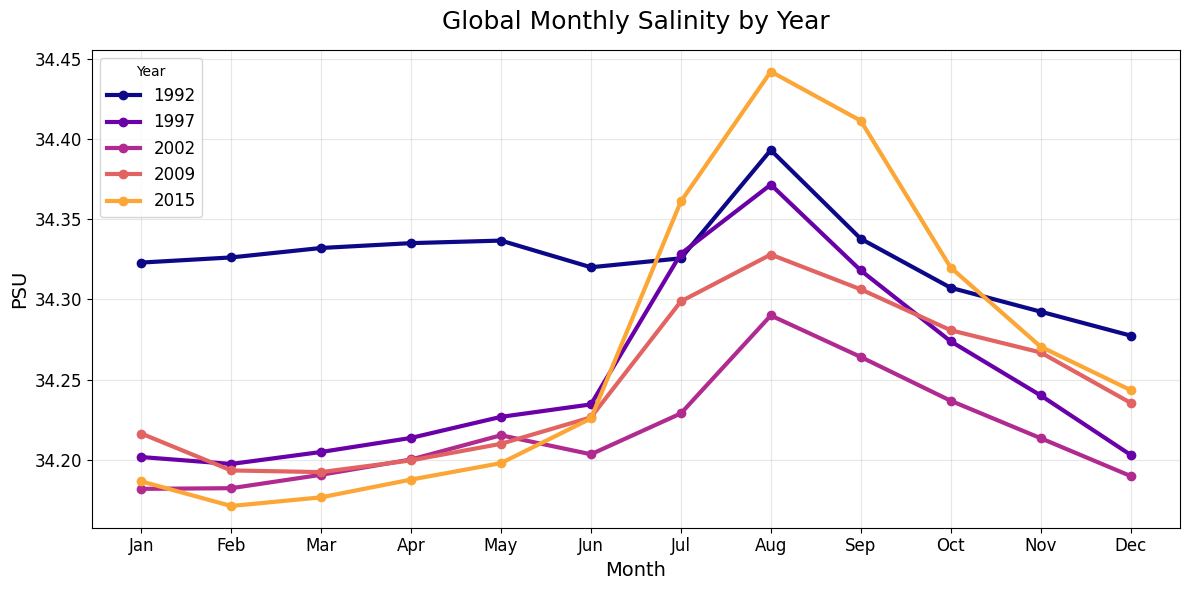

In [7]:
time_series_plot(sss_df, "sss", [30, 40], ["PSU", "Salinity"]) # monthly salinity 

***Observation:*** We can see that salinity levels are *highest* during July-September and *lowest* during January-June.

***Temporal Salinity Patterns***
- *Moderate ENSO:* 2002 & 2009 average *lower* salinity values

- *Extreme ENSO:* 1997 & 2015 average *higher* spike in salinity values

Now let's look at global salinity patterns during each of the specified years to see *where* salinity levels change.

In [8]:
# GLOBAL MAP PATTERN & ANOMALY FUNCTIONS
def global_maps(data, values, max_min, title_info):
    fig, axes, years = init_global_maps() # init fig & axes
    for idx, year in enumerate(years):
        grid = set_grid(data, year, values)                 # set grid
        # cmap = init_cmap(values)                            # init cmap & min/max
        mesh = set_mesh(axes, idx, grid, max_min, "plasma") # set mesh
        title = f"{year} - Moderate ENSO" if year in [2002, 2009] else f"{year} - Extreme ENSO"
        axes = set_axes(title, axes, idx)                   # set axes
    
    set_cbar(fig, mesh, axes, title_info[0]) # set colorbar features
    plot(f"Global {title_info[1]} Patterns") # plot

def global_anomalies(data, values, max_min, title_info):
    fig, axes, years = init_global_maps() # init fig & axes
    base_grid = set_grid(data, 1992, values)

    for idx, year in enumerate(years):
        anom_grid = set_grid(data, year, values) - base_grid     # set anomaly grid
        # cmap = init_cmap(values)                                 # init cmap & min/max
        mesh = set_mesh(axes, idx, anom_grid, max_min, "plasma") # set anomaly mesh
        title = f"{year} - Moderate ENSO" if year in [2002, 2009] else f"{year} - Extreme ENSO"
        axes = set_axes(title, axes, idx)                        # set axes

    set_cbar(fig, mesh, axes, title_info[0])  # set colorbar features
    plot(f"Global {title_info[1]} Anomalies vs 1992") # plot

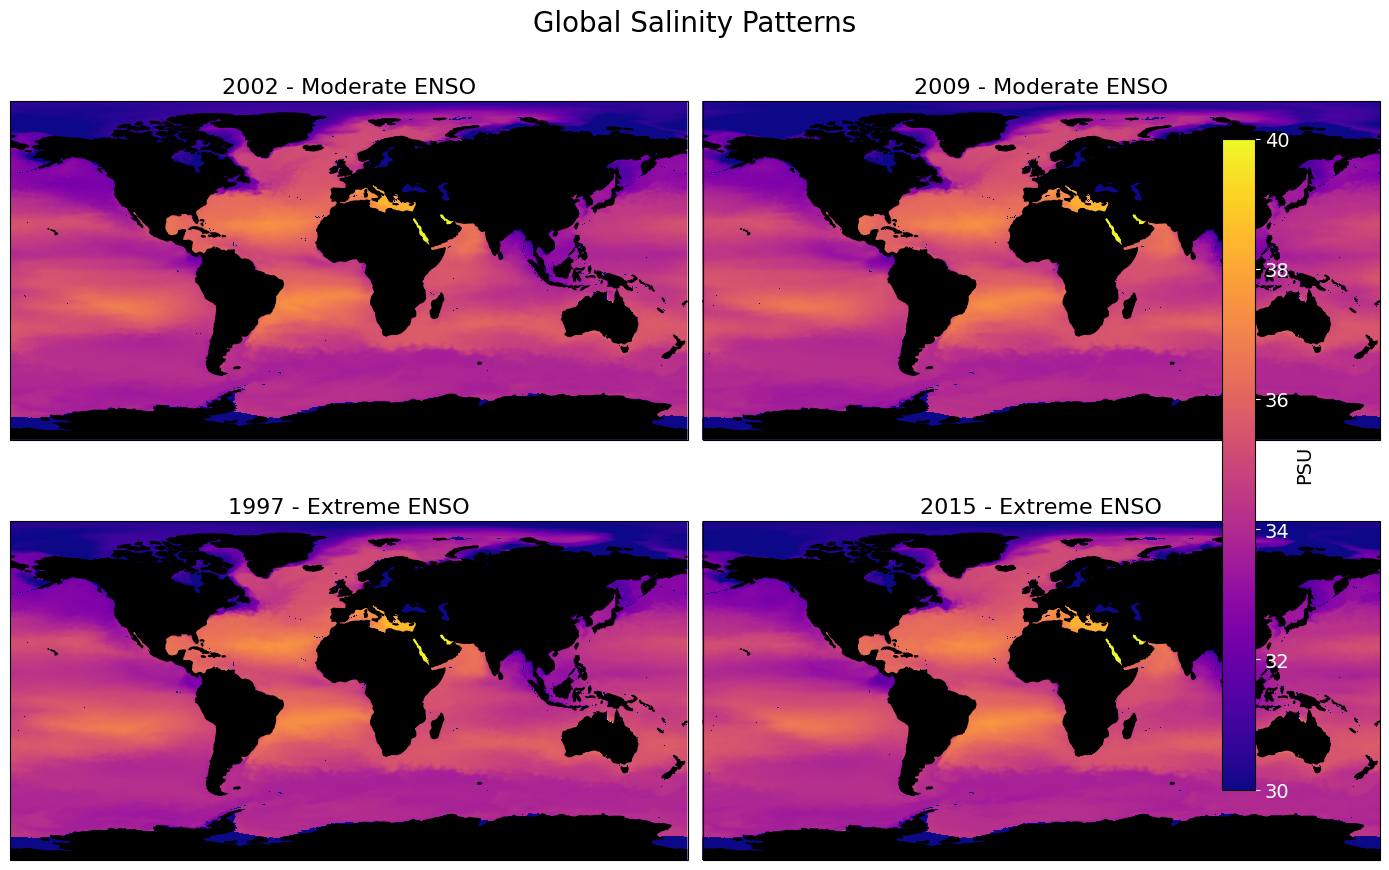

In [9]:
global_maps(sss_df, "sss", [30, 40], ["PSU", "Salinity"]) # global salinity

***Global Salinity Patterns***
|   | Salinity Levels | Regions        | Possible Causes                      |
| ---------- | ------ | -------------- | ------------------------------------ |
| Yellow (+) | Higher | Equator        | -- freshwater, ++ saltwater, ++ evap |
| Purple (-) | Lower  | Polar, Coastal | ++ melting ice, ++ rainfall, -- evap  |

***Observation:*** We can see that the disparity between the salinity levels during moderate vs extreme ENSO years isn't very noticeable in these plots.

So let's look at anomalies of salinity levels in 1992 (init condition) compared to the other years. This is so we can highlight any deviations in salinity levels during moderate and extreme ENSO event years.

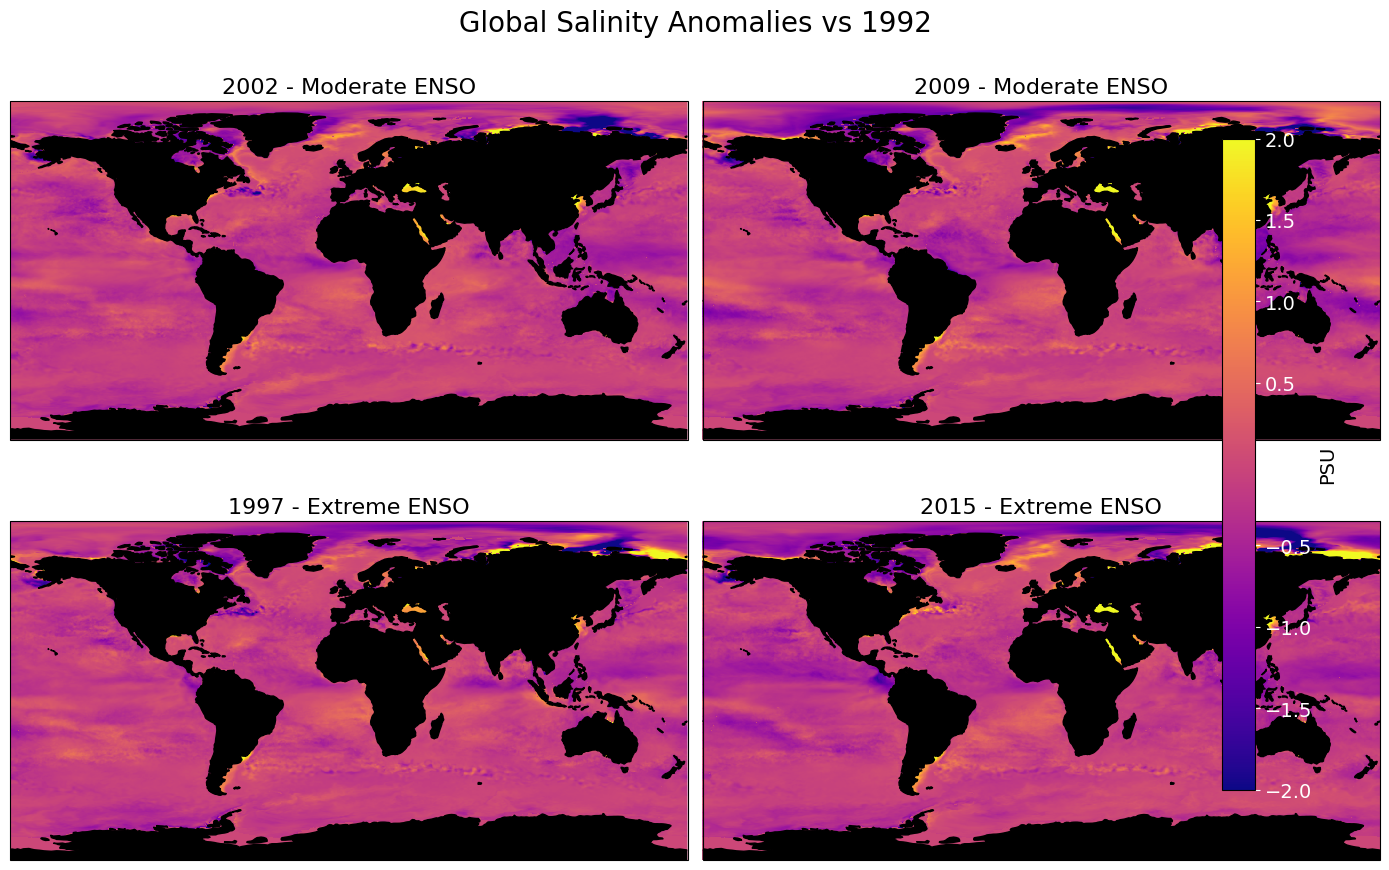

In [10]:
global_anomalies(sss_df, "sss", [-2, 2], ["PSU", "Salinity"]) # global salinity anomalies

***Regional Salinity Anomalies***
|   | Salinity Levels | Regions        | Possible Causes                      |
| ---------- | ------ | -------------- | ------------------------------------ |
| Yellow (+) | Higher | Subtropics | ++ evaporation |
| Purple (-) | Lower  | Equatorial Pacific | ++ rainfall, ++ melting ice|
| Both | Extremes | Coastal | ++ freshwater, ++ melting ice|

- *Coastal:* Amazon/Ganges (++ freshwater), Greenland/Antarctica (++ melting ice)

***Temporal Salinity Patterns***
- *Moderate ENSO:* 2002 & 2009 show *subtle* anomalies in coastal zones and subtropics

- *Extreme ENSO:* 1997 & 2015 show *strong* anomalies in equatorial Pacific

### *2. Sea Surface Temperature (SST)*
Since we know that temperatures will be higher near the equator and lower near the polar regions...

Let's look at a monthly time-series plot of *Sea Surface Temperature (SST)* to see *when* temperatures change.

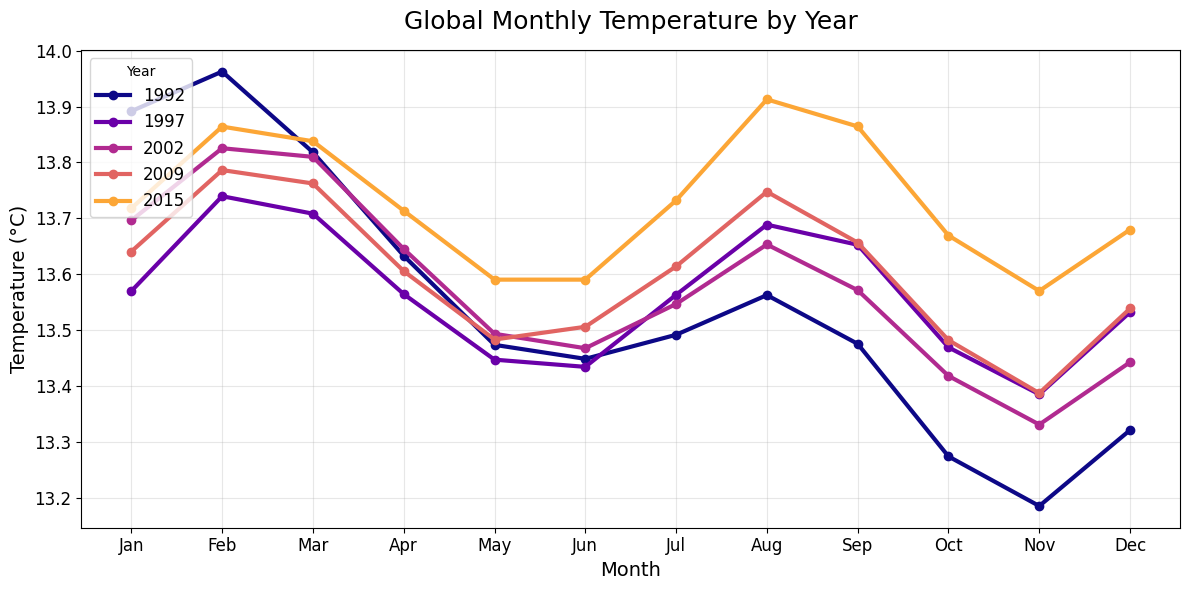

In [11]:
time_series_plot(sst_df, "sst", [-5, 40], ["Temperature (°C)", "Temperature"]) # global monthly temp

***Observation:*** We can see that temperatures are *highest* during February & August, while temperatures noticeably *decline* during September-December.

***Temporal Salinity Patterns***
- *Moderate ENSO:* 2002 & 2009 average moderate temperatures year-round

- *Extreme ENSO:* 1997 & 2015 average higher temperatures year-round

Now let's look at temperature anomaly patterns during each of the specified years compared to 1992 (initial condition) to see *where* temperatures change.

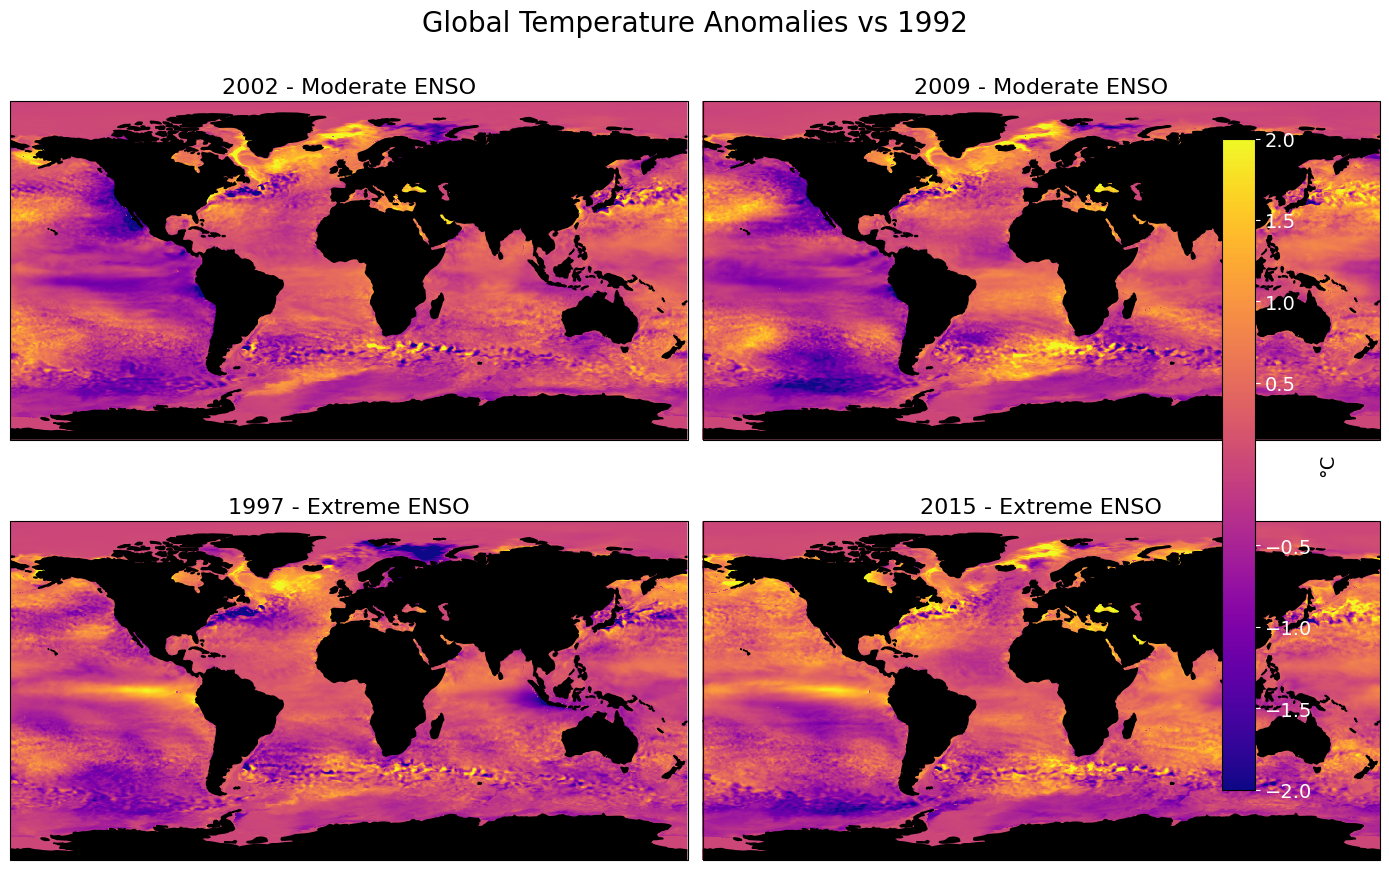

In [12]:
global_anomalies(sst_df, "sst", [-2, 2], ["°C", "Temperature"]) # global temp anomalies

***Regional Temperature Anomalies***
|   | Temperatures | Regions        | Possible Causes                      |
| ---------- | ------ | -------------- | ------------------------------------ |
| Yellow (+) | Warmer | Pacific, Northern, Indian | ++ ENSO/Global warming, -- AMOC |
| Purple (-) | Cooler | North Atlantic, East Pacific, Southern, Coastal | ++ Upwelling, ++ freshwater |

### *3. Latent Heat Flux (LHTFL)*
Third, let's look at a monthly time-series plot of *Latent Heat Flux (LHTFL)* to see *when* heat is transfered.

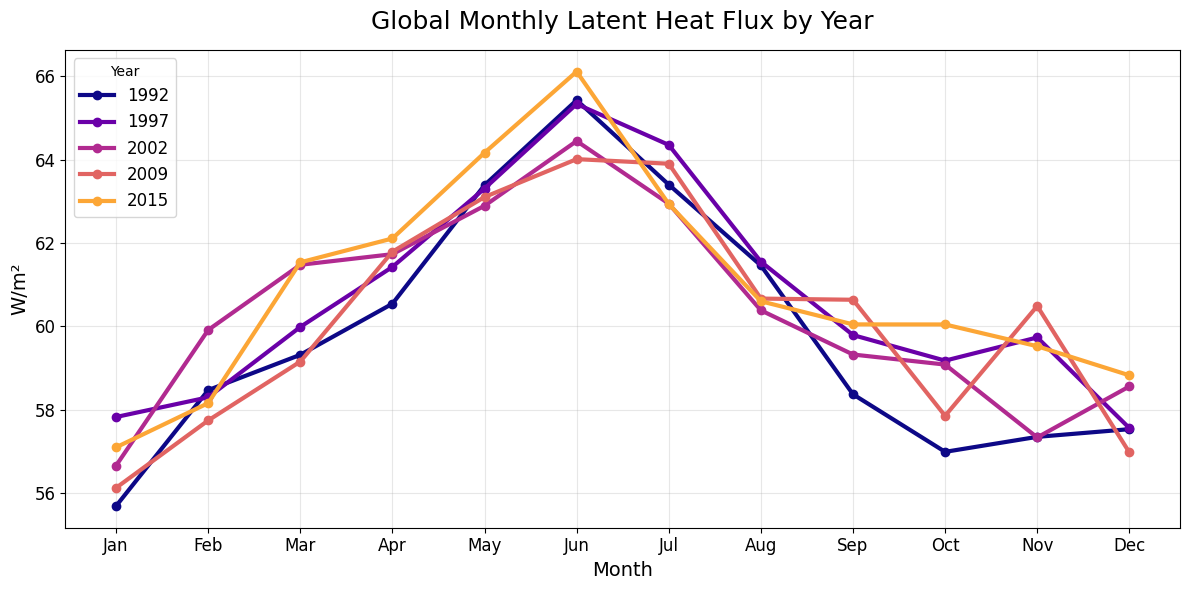

In [13]:
time_series_plot(lhtfl_df, "lhtfl", [-200, 200], ["W/m²", "Latent Heat Flux"]) # global monthly LHTFL

***Observation:*** We can see that latent heat is transfered *most* during May-July with a steady *decline* until the *least* amount of heat transfer during October-January.

***Temporal Salinity Patterns***
- *Moderate ENSO:* 2002 & 2009 show more variable heat transfer patterns

- *Extreme ENSO:* 1997 & 2015 show higher overall flux values

Now let's look at global patterns for latent heat flux during each of the specified years to see *where* heat is transfered.

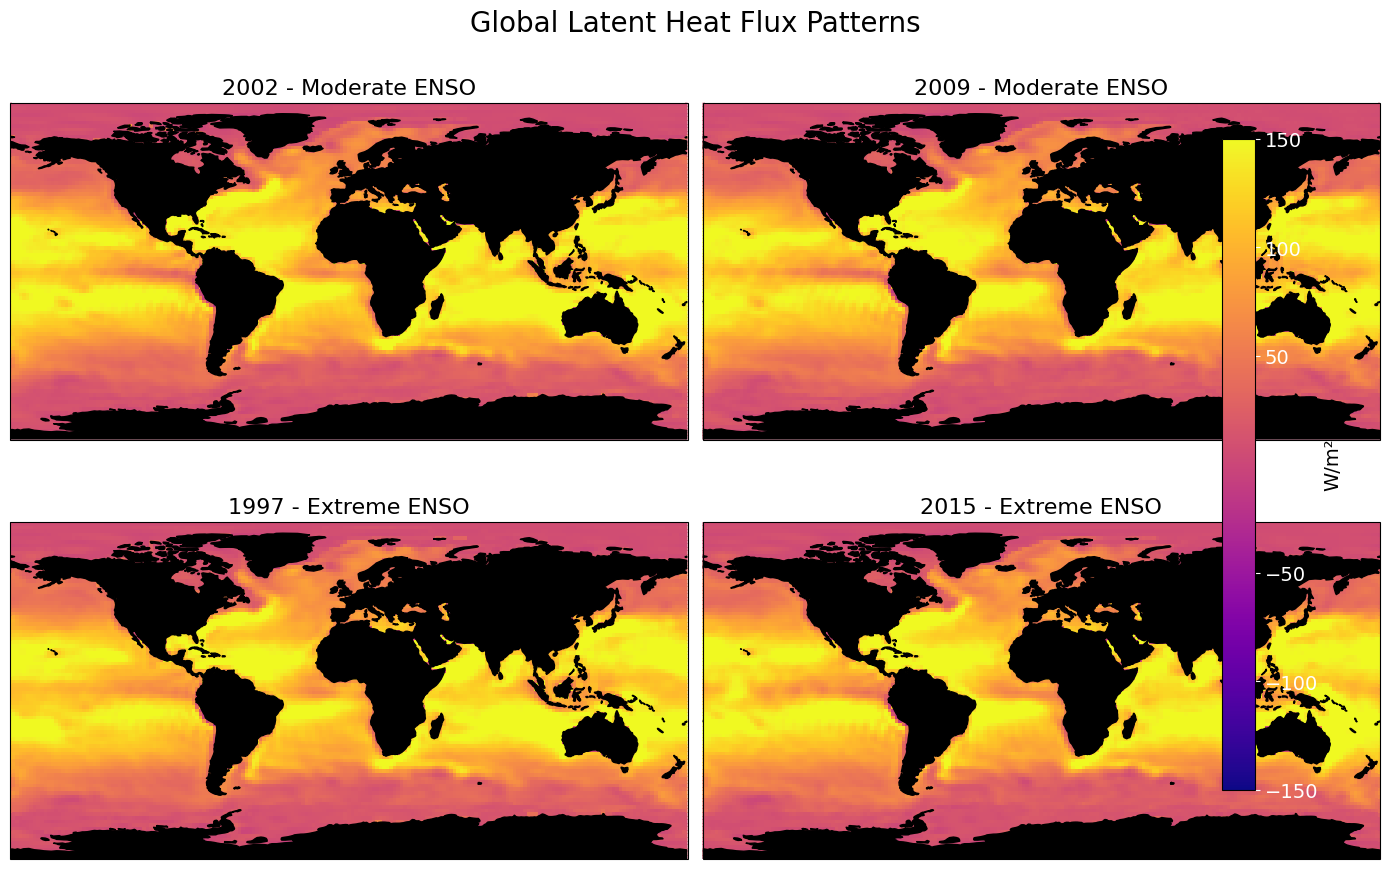

In [14]:
global_maps(lhtfl_df, "lhtfl", [-150, 150], ["W/m²", "Latent Heat Flux"]) # global heat flux

***Global Heat Flux Patterns***
|  | LHTFL | Regions | Possible Causes |
| ---------- | ----------| ----------| ----------|
| Yellow (+) | High | Subtrop Atlantic, West Pacific, Indian | ++ evaporation |
| Purple (-) | Low | Polar, East Pacific, Coastal | ++ condensation |

Since LHTFL patterns are most prevalent in subtropical oceans, let's look at the LHTFL comparison during El Niño years 2009, 1997, and 2015.

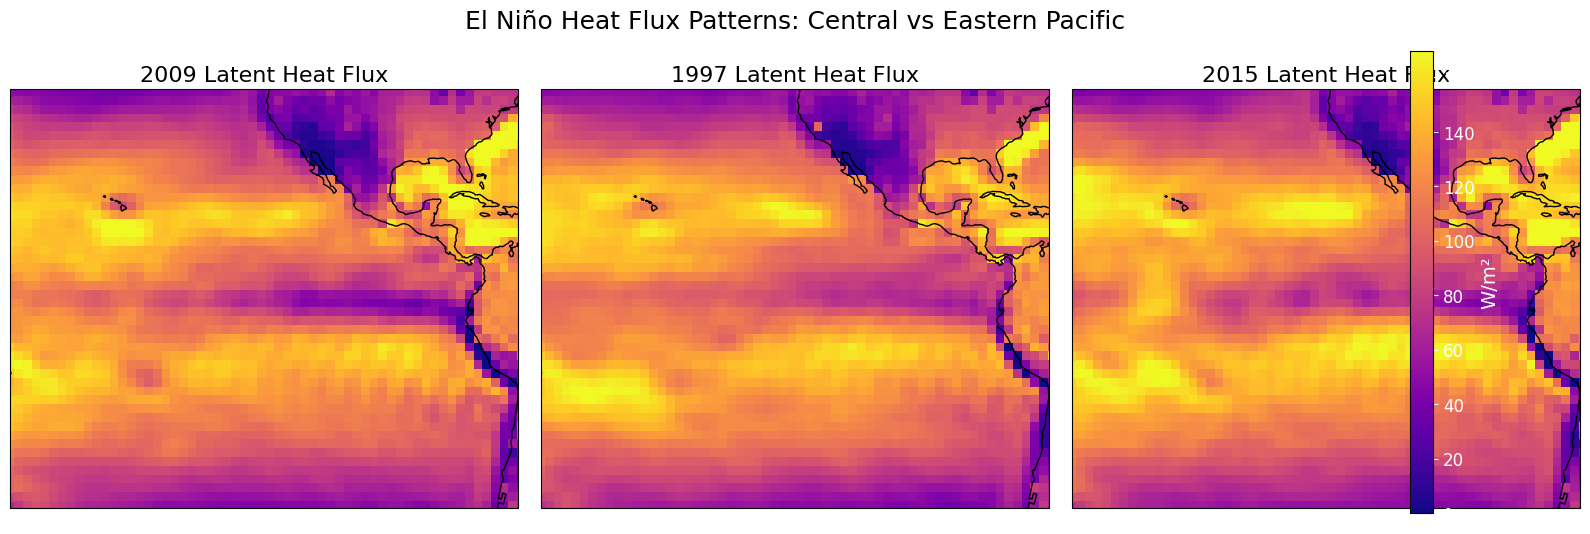

In [15]:
# EL NIÑO HEAT FLUX COMPARISON
def elniño_heat_flux_comparison(lhtfl_df, years = [2009, 1997, 2015]):
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    pacific = [-180, -70, -30, 30] # pacific region
    vmin, vmax = lhtfl_df["lhtfl"].quantile([0.05, 0.95])  # robust scaling
    
    for idx, year in enumerate(years):
        yearly_data = lhtfl_df[lhtfl_df["time"].dt.year == year]
        grid = yearly_data.pivot_table(index="latitude", columns="longitude", values="lhtfl")
        
        mesh = axes[idx].pcolormesh(
            grid.columns,
            grid.index,
            grid.values,
            cmap="plasma",
            vmin=vmin,
            vmax=vmax,
            transform=ccrs.PlateCarree()
        )
        axes[idx].set_title(f"{year} Latent Heat Flux", fontsize=16)
        axes[idx].set_extent(pacific)
        axes[idx].add_feature(cfeature.LAND, facecolor="black")
        axes[idx].coastlines()
    
    cbar = fig.colorbar(mesh, ax=axes, orientation="vertical", fraction=0.02, pad=0.08)  # Increased pad
    cbar.set_label("W/m²", fontsize=14, color="white")
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(cbar.ax.get_yticklabels(), color='white', fontsize=12)
    plt.suptitle("El Niño Heat Flux Patterns: Central vs Eastern Pacific", fontsize=18, y=0.95)
    plt.tight_layout()
    plt.show()

elniño_heat_flux_comparison(lhtfl_df)

***El Niño Heat Flux Patterns***

- *2009:* maximum (yellow) centered towards the *Central Pacific*, where warming and evaporation-driven flux shifts westward

- *1997 & 2015:* broader and more intense in the *Eastern Pacific*, where ++evaporation enhances heat transfer

## Analysis & Comparisons

Finally, we're going to look into the change over time (from 1992-2015) of *latent heat flux* in the ocean's surface based on factors like sea surface *salinity* and *temperature*.

### *Questions to Address*
1. Does salinity variability modulate ocean-atmosphere coupling during extremes?
3. How consistent are flux responses between the two record El Niño events (1997 vs 2015)

In [16]:
# PREPROCESS & MERGE FUNCTIONS
def preprocess_data(df, value_col):
    data = df.copy()
    data[value_col] = data[value_col].where(data[value_col].between(-50, 50)) # realistic values
    data["time"] = data["time"].dt.to_period("M").dt.to_timestamp() # convert to monthly
    data["latitude"] = data["latitude"].round(1)                    # round coords
    data["longitude"] = data["longitude"].round(1)
    data = data.dropna(subset=[value_col])
    return data

sss_clean = preprocess_data(sss_df, "sss")
sst_clean = preprocess_data(sst_df, "sst")
lhtfl_clean = preprocess_data(lhtfl_df, "lhtfl")

# merge on time, lat, long
def merge_datasets(sss_clean, sst_clean, lhtfl_clean):
    temp = pd.merge(sss_clean, sst_clean, on=["time", "latitude", "longitude"], how="inner")
    final_df = pd.merge(temp, lhtfl_clean, on=["time", "latitude", "longitude"], how="inner")
    return final_df

merged_df = merge_datasets(sss_clean, sst_clean, lhtfl_clean) # merge all datasets
# monthly_avg = merged_df.groupby(["time", "latitude", "longitude"]).mean().reset_index() # for local
monthly_avg = merged_df.groupby(merged_df["time"].dt.to_period("M")).mean(numeric_only=True).reset_index() # for global
monthly_avg["sss_norm"] = (monthly_avg["sss"] - monthly_avg["sss"].mean()) / monthly_avg["sss"].std()

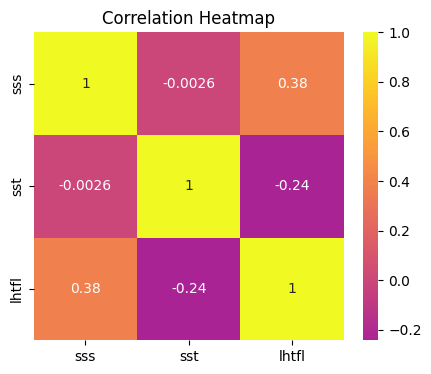

In [17]:
def correlation_heatmap(data, vars_list=["sss", "sst", "lhtfl"]):
    plt.figure(figsize=(5,4))
    corr = monthly_avg[vars_list].corr()
    sns.heatmap(corr, annot=True, cmap="plasma", center=0)
    plt.title("Correlation Heatmap")
    plt.show()

correlation_heatmap(merged_df)

***Relationship to Latent Heat Flux***
|  | Correlation | Trend | LHTFL |
| ---------- | ----------| -------- | -------- |
| SSS | 0.38 | Moderate (+) | Higher |
| SST | -0.24 | Moderate (-) | Lower |

***DISCLAIMER:*** These values reflect the selection of years spanning neutral, moderate, and extreme ENSO events, combined with a global dataset that emphasizes tropical and southern ocean regions. Consequently, the patterns observed here reflect high climate variability and may not align with broader global ocean-atmosphere trends.

Now let's visualize these correlation values in *Density Plots* to see where the data clusters in varying ranges of salinity and temperature.

In [18]:
# MERGED COMPARISON PLOT FUNCTION
def comparison_plot(type, data, x_vars, y_var="lhtfl"):
    fig, axes = plt.subplots(1, len(x_vars), figsize=(14, 6))
    if type == "density": 
        plot_order = sorted(x_vars, key=lambda x: 0 if "sss" in x.lower() else 1) # SSS plotted first

    for idx, var in enumerate(x_vars):
        if type == "scatter":
            sns.regplot(
                data=data,
                x=var,
                y="lhtfl",
                ax=axes[idx],
                scatter_kws={"alpha": 0.3, "color": "#9c179e"},
                line_kws={"color": "#f8961e", "linewidth": 2.5}
            )
        elif type == "density":
            sns.kdeplot(
                data=data,
                x=var,
                y=y_var,
                fill=True,
                cmap="plasma",
                bw_adjust=0.5,
                ax=axes[idx]
            )
        axes[idx].set_title(f"{var.upper()} vs {y_var.upper()}", fontsize=16, pad=5)
        axes[idx].set_xlabel(var, fontsize=14)
        axes[idx].set_ylabel(y_var, fontsize=14)
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f"{type.title()} Plot Comparisons: Monthly Averages", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

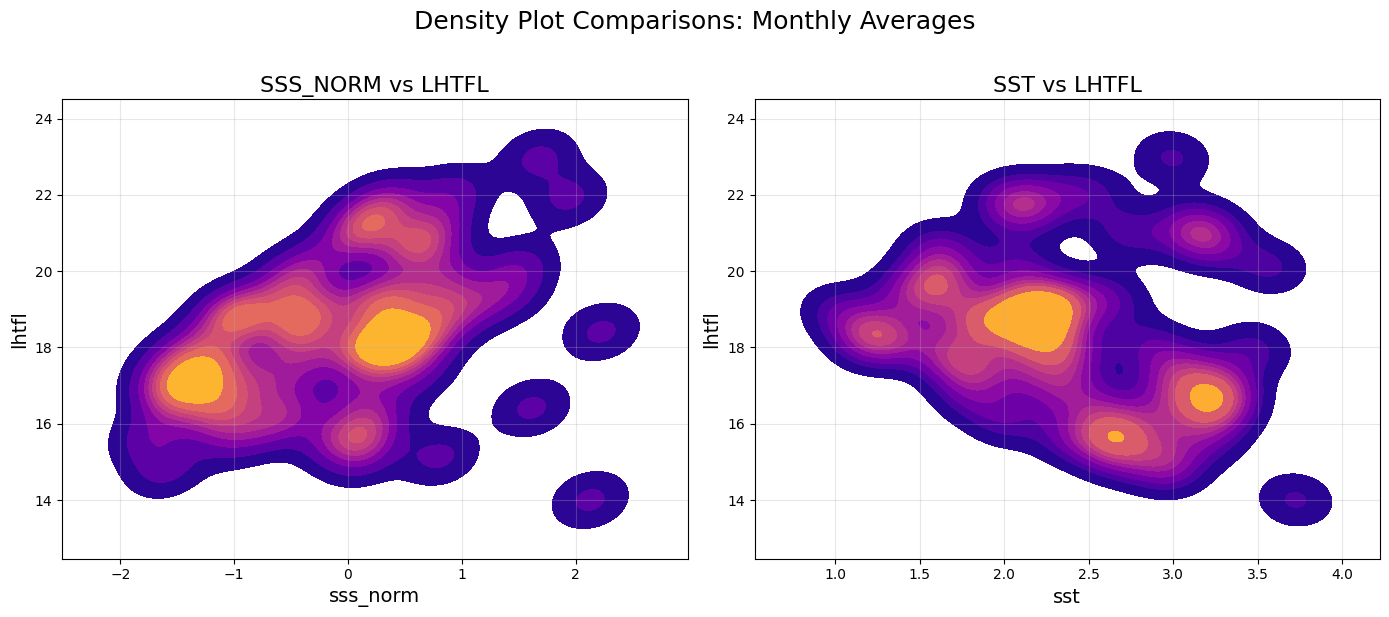

In [19]:
comparison_plot("density", monthly_avg, ["sss_norm", "sst"]) # density plots

***Observation:*** High density clusters (yellow) tend to occur around average salinity & temperature values, suggesting that LHTFL is generally concentrated around average ocean conditions.

***SSS vs LHTFL***
- *Low-Salinity (L):* ++ freshwater, ++ evaporation, ++ LHTFL

- *High-Salinity (R):* areas of persistent evaporation

***SST vs LHTFL***
- *Warm Water:* normally ++ evaporation, but ENSO events can -- wind and ++ humidity, -- LHTFL

- *Cold Water:* -- evaporation, -- LHTFL

Now let's look at how salinity variability affects heat flux during extreme El Niño years 1997 and 2015.

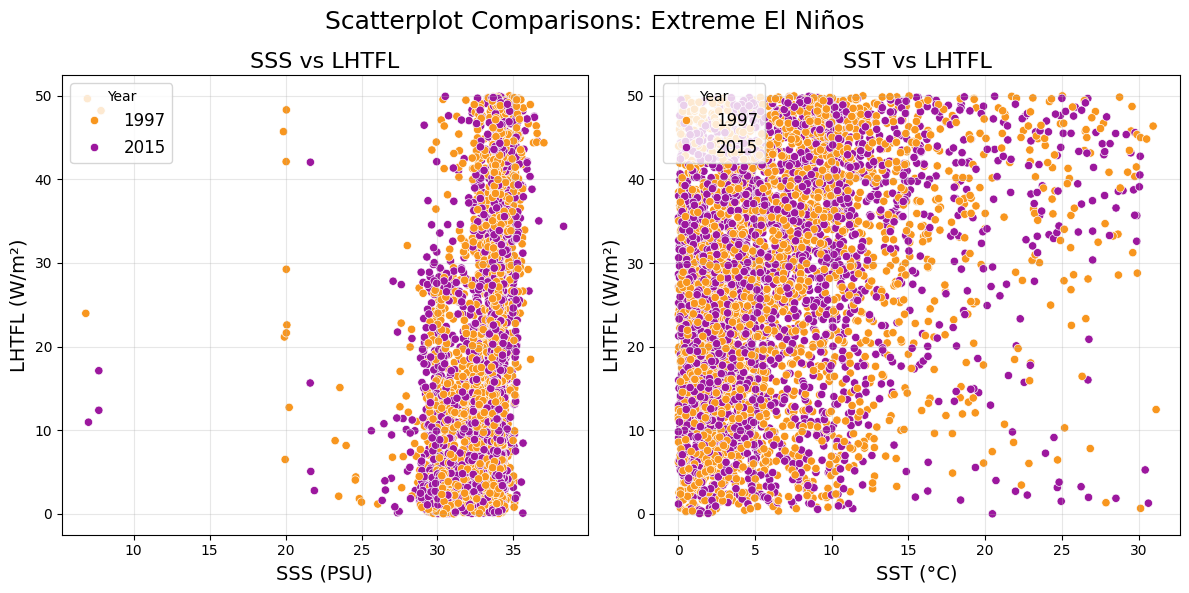

In [20]:
# EXTREME EL NIÑO COMPARISON (1997 vs 2015)
def extreme_ENSO_comparison(data=[sss_clean, sst_clean], x_vars=["sss", "sst"], lhtfl_df=lhtfl_clean, years=[1997, 2015]):
    fig, axes = plt.subplots(1, len(x_vars), figsize=(12, 6))
    axes = np.array(axes).flatten()  # consistent idx
    custom_palette = {1997: "#f8961e", 2015: "#9c179e"}

    for idx, (df, var) in enumerate(zip(data, x_vars)):
        df_filtered = df[df["time"].dt.year.isin(years)]
        lhtfl_filtered = lhtfl_df[lhtfl_df["time"].dt.year.isin(years)]
        merged = pd.merge(df_filtered, lhtfl_filtered, on=["time", "latitude", "longitude"], suffixes=(f"_{var}", "_lhtfl"))
        merged = merged[(merged[var] > 0) & (merged["lhtfl"] > 0)] # filter
        merged["year"] = merged["time"].dt.year

        sns.scatterplot(
            ax=axes[idx],
            data=merged.sample(5000, random_state=42),
            x=var,
            y="lhtfl",
            hue="year",
            palette=custom_palette
        )
        unit = "PSU" if var == "sss" else "°C"
        axes[idx].set_title(f"{var.upper()} vs LHTFL", fontsize=16, pad=5)
        axes[idx].legend(title="Year", loc="upper left", fontsize=12)
        axes[idx].set_xlabel(f"{var.upper()} ({unit})", fontsize=14)
        axes[idx].set_ylabel("LHTFL (W/m²)", fontsize=14)
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle("Scatterplot Comparisons: Extreme El Niños", fontsize=18)
    plt.tight_layout()
    plt.show()

extreme_ENSO_comparison() # SSS extreme El Niño comparison

***Relationship to Latent Heat Flux in 1997 & 2015***
|  | Correlation | Trend |
| ---------- | ----------| ----------|
| SSS | Weak (N) | Overlap without distinct trends |
| SST | Weak (+) | Broad spread, slight positive trend at higher SST ranges |

***Observations:*** We can see that during extreme ENSO events, salinity doesn't fluctuate enough to drive changes in LHTFL. And temperature only increases LHTFL slightly at higher temperature ranges.

***DISCLAIMER:*** These relationships differ from long-term global correlations due to the high variability and unique atmospheric conditions present during extreme El Niño years.

## Findings

### *Salinity*
Salinity doesn't significantly modulate LHTFL variability, acting as a passive indicator of long-term evaporation rather than an active driver. Both global and ENSO analyses show weak, inconsistent relationships with LHTFL.

### *Temperature*
Temperature has a moderate influence on LHTFL, with higher temperatures generally associated with increased flux. And temperature is affected by atmospheric conditions like wind and humidity, especially during ENSO events.

### *ENSO Events*
The 1997 and 2015 El Niño events show similar spatial patterns of elevated LHTFL but differ in intensity. These differences reflect variations in temperature anomalies and background factors, such as global warming.

### *Conclusion*
While salinity plays a secondary role, LHTFL is primarily driven by temperature and regional climate dynamics, with the strongest ocean-atmospheric coupling occuring in tropical and southern regions.